# Plot Run Data
This notebook plots the performance of a run to assess the optimization performance and system utilization.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

Load the run information 

In [2]:
run_info = pd.read_csv('run_data.csv')

Pick one

In [3]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0]
print(run_info)

path            runs/reallocate-N100-P4-050124-101957
start_time                        2024-01-05 10:19:57
num_guesses                                       100
num_parallel                                        4
retrain_wait                                       20
dim                                                 4
runtime                                             2
runtime_var                                         1
opt_delay                                        20.0
file                                  reallocation.py
worker_count                                        4
n_evals                                            53
Name: 0, dtype: object


## Load in Result File
This file is the list of the quantum chemistry results

In [4]:
run_path = Path(run_info['path'])

In [5]:
with open(run_path / 'results.json') as fp:
    result_data = pd.json_normalize([json.loads(l) for l in fp], sep='_')

Plot the time since first result

In [6]:
result_data['walltime'] = result_data['timestamp_result_received'] - result_data['timestamp_created'].min()

Plot the rate at which we aquired new results

## Evaluate Runtimes
Estimate the runtimes of the QC code

In [7]:
result_data['time_running'].describe()

count    103.000000
mean      12.336803
std       13.653985
min        0.956067
25%        3.519447
50%        7.471832
75%       15.221390
max       76.415690
Name: time_running, dtype: float64

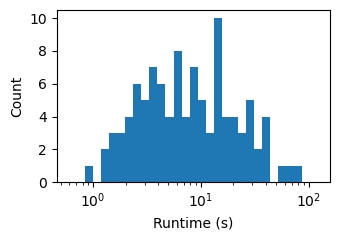

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

min_log = np.log10(result_data.time_running).min()
max_log = np.log10(result_data.time_running).max()
ax.hist(result_data['time_running'], bins=np.logspace(min_log - 0.2, max_log + 0.2, 32))
ax.set_xscale('log')

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Count')
fig.tight_layout()

## Evaluate Performance
See if we are getting better over time

In [9]:
result_data['time_running'].describe()

count    103.000000
mean      12.336803
std       13.653985
min        0.956067
25%        3.519447
50%        7.471832
75%       15.221390
max       76.415690
Name: time_running, dtype: float64

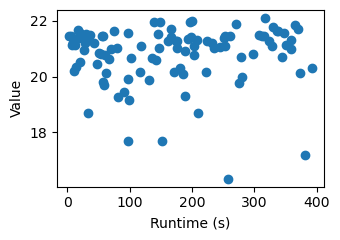

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.scatter(result_data['walltime'], result_data['value'])

ax.set_xlabel('Runtime (s)')
ax.set_ylabel('Value')
fig.tight_layout()

## Plot the Number of Simulations Being Run at a Time
We can look at the runtime log to get when simualtions tasks start computing and when they finish

In [11]:
with open(run_path / 'run.log') as fp:
    log_data = pd.DataFrame(f.rstrip() for f in fp)
log_data.rename(columns={0: 'msg'}, inplace=True)
log_data['msg_num'] = log_data['msg'].str.match(r'^[\d]').cumsum()
log_data = log_data.groupby('msg_num').agg({'msg': lambda x: '\n'.join(x)})

In [12]:
log_data['time'], log_data['module'], log_data['level'], log_data['content'] = zip(*log_data['msg'].str.split(" - ", n=3))

Compute the time since first message

In [13]:
log_data['time'] = pd.to_datetime(log_data['time'], utc=False)

In [14]:
log_data['walltime'] = (log_data['time'] - log_data['time'].iloc[0]).apply(lambda x: x.total_seconds())

In [15]:
start_time = log_data['time'].iloc[0].timestamp()

Find the events related to calculations starting and finishing

In [16]:
start_time = result_data['timestamp_created'].min()

In [17]:
events = [{'time': 0, 'active_delta': 0}]
events.extend({'time': t - start_time, 'active_delta': -1} for t in 
          (result_data['timestamp_compute_started'] + result_data['time_running']))
events.extend([{'time': t - start_time, 'active_delta': 1} for t in result_data['timestamp_compute_started']])
events = pd.DataFrame(events)

Make the results easier to plot

In [18]:
events.sort_values('time', ascending=True, inplace=True)

In [19]:
events['num_active'] = events['active_delta'].cumsum()

Compute worker utilization

In [20]:
events['queue_length'] = events['num_active']

In [21]:
events['utilization'] = np.clip(events['queue_length'] / run_info['worker_count'], 0, 1)

In [22]:
utilization_int = (np.diff(events['time'].values) * events['utilization'].values[:-1]).cumsum()

Compute the cumulative utilization

In [23]:
def cumulative_utilization(time: float) -> float:
    """Compute average utilization over time"""
    # Integrating knowing that we have a piecewise functions
    # Integrate over all of the pieces before the current piece
    past_events = events[events.time <= time]
    if len(past_events) <= 1:
        return 0.0
    past_util = (np.diff(past_events['time'].values) * past_events['utilization'].values[:-1]).sum()
    
    # Integrate the current piece
    current_event = past_events.iloc[-1]
    current_util = (time - current_event.time) * current_event.utilization
    return (past_util + current_util) / time

In [24]:
%%time
times = np.linspace(0, events.time.max(), 1024)
utilization = np.array([cumulative_utilization(x) for x in times])

CPU times: user 184 ms, sys: 16.3 ms, total: 200 ms
Wall time: 193 ms


Plot the queue length and utilization

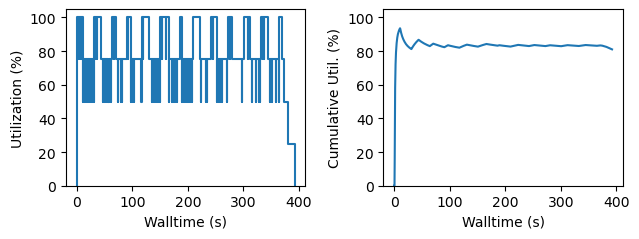

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

# Plot the queue length
ax = axs[0]
ax.step(events['time'], events['utilization'] * 100, where='post')
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Utilization (%)')
ax.set_ylim(0, 105)

ax = axs[1]
ax.plot(times, utilization * 100)
ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Cumulative Util. (%)')
ax.set_ylim(0, 105)

fig.tight_layout()
fig.savefig('utilization.png', dpi=320)

## Plot Assignment to Different "Nodes"
See how work is distributed

In [26]:
with open(run_path / 'retrain.json') as fp:
    retrain_data = pd.json_normalize([json.loads(l) for l in fp], sep='_')

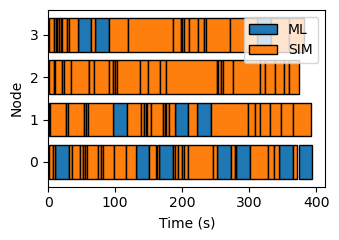

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for label, data in zip(['ML', 'SIM'], [retrain_data, result_data]):
    data["worker"] = data['worker_info_PARSL_WORKER_RANK'].apply(int)
    ax.barh(y=data["worker"], width=data["time_running"], left=data["timestamp_compute_started"] - start_time, label=label, edgecolor='k')
    
ax.set_yticks(np.arange(data["worker"].max() + 1))
ax.set_ylabel('Node')

ax.set_xlim([0, max(ax.get_xlim())])

ax.set_xlabel('Time (s)')
ax.legend()
fig.tight_layout()
fig.savefig('figures/allocation.png', dpi=320)